In [212]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing
import sklearn.neural_network

In [213]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
warnings.simplefilter(action='ignore', category=ImportWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=ResourceWarning)

In [214]:
import theano
import theano.tensor as T

In [215]:
def sgd(cost, params, lr=0.001, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append((p, p - lr * g))
    return updates

In [216]:
def sgd_momentum(cost, params, lr=0.001, beta=0.9,epsilon=1e-6):  #no bias correction
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        v= theano.shared(p.get_value() * 0.)
        vc= beta*v + (1-beta)*g
        updates.append((v,vc))
        updates.append((p, p - lr * vc))
    return updates

In [217]:
def adagrad(cost, params, lr=0.001, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = acc + g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

In [218]:
def adam(cost, params, lr=0.001, beta=0.9, epsilon=1e-6):  #no bias correction, T.sqrt if **0.5 not work
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        m=theano.shared(p.get_value()* 0.)
        v=theano.shared(p.get_value()* 0.)
        mc = beta*m + (1-beta)*g
        vc = beta*v + (1-beta)*g**2
        updates.append((m,mc))
        updates.append((v,vc))
        updates.append((p, p - lr * mc/(epsilon+vc**0.5)))
    return updates

In [219]:
def RMSprop(cost, params, lr=0.001, beta=0.9,epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        v= theano.shared(p.get_value() * 0.)
        vc = beta*v + (1-beta)*g**2
        updates.append((v,vc))
        updates.append((p, p - lr * g/(epsilon+vc**(0.5))))
    return updates

In [220]:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='latin-1')
f.close()

In [221]:
train_set[0][train_set[0]>=0.5]=1
train_set[0][train_set[0]<0.5]=0

In [222]:
valid_set[0][valid_set[0]>=0.5]=1
valid_set[0][valid_set[0]<0.5]=0

In [223]:
test_set[0][test_set[0]>=0.5]=1
test_set[0][test_set[0]<0.5]=0

In [224]:
x_train=theano.function([], T.concatenate([train_set[0], valid_set[0]]))()

In [225]:
x_test = theano.function([], theano.shared(test_set[0]))()

In [226]:
n_hidden = 100 # the size of hidden layers in MLP
n_latent = 2 # the dimension of z
n_input = x_train.shape[1] # the dimension of x's feature space
batch_size = 100
n_epochs = 10000

In [227]:
def init_w(shape):
    x = np.random.randn(*shape)
    float_x = np.asarray(x * 0.01, dtype=theano.config.floatX)
    return theano.shared(float_x)

In [228]:
# Parameters
# Gaussian MLP weights and biases (encoder)
#initialize \phi 

b3 = init_w((n_hidden, ))
b2 = init_w((n_latent, ))
b1 = init_w((n_latent, ))


W3 = init_w((n_input, n_hidden))
W2 = init_w((n_hidden, n_latent))
W1 = init_w((n_hidden, n_latent))


In [229]:
# Gaussian Encoder
x = T.matrix("x")
h_encoder = T.tanh(T.dot(x, W3) + b3)
mu = T.dot(h_encoder, W1) + b1
log_sig2 = T.dot(h_encoder, W2) + b2
# This expression is simple (not an expectation) because we're using normal priors and posteriors
DKL = (1.0 + log_sig2 - mu**2 - T.exp(log_sig2)).sum(axis = 1)/2.0

In [230]:
# Bernoulli MLP weights and biases (decoder)
bernoulli_b1 = init_w((n_hidden, ))
bernoulli_b2 = init_w((n_input, ))

bernoulli_W1 = init_w((n_latent, n_hidden))
bernoulli_W2 = init_w((n_hidden, n_input))

In [231]:
# Bernoulli Decoder
std_normal = T.matrix("std_normal") 
z = mu + T.sqrt(T.exp(log_sig2))*std_normal
h_decoder = T.tanh(T.dot(z, bernoulli_W1) + bernoulli_b1)
y = T.nnet.sigmoid(T.dot(h_decoder, bernoulli_W2) + bernoulli_b2)
log_likelihood = -T.nnet.binary_crossentropy(y, x).sum(axis = 1)


In [232]:
# Only the weight matrices W will be regularized (weight decay)
W = [W3, W1, W2, bernoulli_W1, bernoulli_W2]
b = [b3, b1, b2, bernoulli_b1, bernoulli_b2]
params = W + b

In [233]:
lower_bound = (DKL + log_likelihood).mean()
cost = -lower_bound

In [ ]:
'''Using Adagrad'''
updates = adagrad(cost, params, lr=0.02)

In [ ]:
train_model = theano.function(inputs=[x, std_normal], 
                              outputs=cost, 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)

In [ ]:
%%time

training_ada = []
#validation = []
for i in range(n_epochs):
    minibatch_train = [ x_train[j] for j in np.random.randint(0,x_train.shape[0],batch_size) ]

    #val_cost = eval_model(x_test, np.random.normal(size = (len(x_test), n_latent)))
    train_cost = train_model(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training_ada.append(train_cost)
    #validation.append(val_cost)    

In [ ]:
plt.ylabel("Lower bound")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(-np.array(training_ada))
plt.show()

In [234]:
'''Using RMSprop'''
updates = RMSprop(cost, params, lr=0.02)

In [235]:
train_model = theano.function(inputs=[x, std_normal], 
                              outputs=cost, 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)
                              

In [236]:
%%time

training_RMSprop = []
#validation = []
for i in range(n_epochs):
    minibatch_train = [ x_train[j] for j in np.random.randint(0,x_train.shape[0],batch_size) ]

    #val_cost = eval_model(x_test, np.random.normal(size = (len(x_test), n_latent)))
    train_cost = train_model(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training_RMSprop.append(train_cost)
    #validation.append(val_cost)    

CPU times: user 6min 50s, sys: 11min 11s, total: 18min 1s
Wall time: 2min 16s


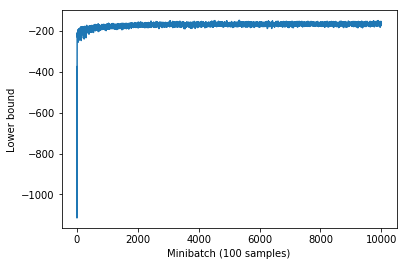

In [237]:
plt.ylabel("Lower bound")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(-np.array(training_RMSprop))
plt.show()

In [ ]:
'''Repeat with updates = different gradient method: sgd, sgd_momentum,adagrad,adam, RMSprop'''

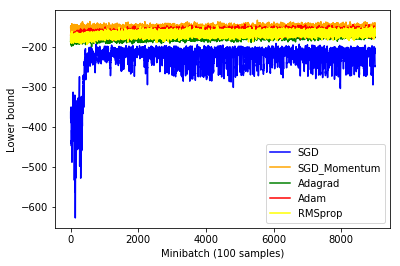

In [241]:
plt.ylabel("Lower bound")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(-np.array(training_sgd[1000:]),'blue',label='SGD')
plt.plot(-np.array(training_sgd_momentum[1000:]),'orange',label='SGD_Momentum')
plt.plot(-np.array(training_adagrad[1000:]),'green',label='Adagrad')
plt.plot(-np.array(training_adam[1000:]),'red',label='Adam')
plt.plot(-np.array(training_RMSprop[1000:]),'yellow',label='RMSprop')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.show()